In [1]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

In [11]:
# Load the dataset
file_path = "/home/jovyan/STA365/Ecommerce_Consumer_Behavior_Analysis_Data.csv"
df = pd.read_csv(file_path)

# Convert 'Purchase_Amount' to numeric by removing '$' and converting to float
df["Purchase_Amount"] = df["Purchase_Amount"].replace('[\$,]', '', regex=True).astype(float)

# Select relevant columns
df_cleaned = df[["Age", "Purchase_Amount"]].dropna()

# Standardize 'Age' for better convergence
scaler = StandardScaler()
df_cleaned["Age_Standardized"] = scaler.fit_transform(df_cleaned[["Age"]])
# Downsample the dataset to 500 samples for computational efficiency
df_sampled = df_cleaned.sample(n=500, random_state=42)
df_sampled.head()

,Age,Purchase_Amount,Age_Standardized
521,33,444.05,-0.139487
737,38,178.21,0.395355
740,36,85.52,0.181418
660,33,55.73,-0.139487
411,42,442.15,0.823228


In [12]:
x1_data = df_sampled[["Age_Standardized"]].values  # Predictor (Age standardized)
x2_data= df_sampled[["Purchase_Amount"]].values
print(np.min(x1_data), np.mean(x1_data))

-1.7440118129524678 0.035513488830974965


In [5]:
import pymc as pm

# Model for x1
with pm.Model() as marginal_x1:
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    x1 = pm.Normal('x1', mu=mu, sigma=sigma, observed=x1_data)

    trace_x1 = pm.sample()

# Model for x2
with pm.Model() as marginal_x2:
    alpha = pm.HalfNormal('alpha', sigma=1)
    beta = pm.HalfNormal('beta', sigma=1)
    x2 = pm.Gamma('x2', alpha=alpha, beta=beta, observed=x2_data)
    trace_x2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [6]:
import numpy as np
from scipy.stats import gamma, norm

# Obtain posterior means of the marginal parameters
mu_mean = trace_x1.posterior['mu'].values.mean()
sigma_mean = trace_x1.posterior['sigma'].values.mean()
alpha_mean = trace_x2.posterior['alpha'].values.mean()
beta_mean = trace_x2.posterior['beta'].values.mean()


# Transform x1 and x2 to uniform margins
u1 = norm.cdf(x1_data, loc=mu_mean, scale=sigma_mean)
u2 = gamma.cdf(x2_data, a=alpha_mean, scale=1/beta_mean)

# Map uniform margins to Gaussian space
z1 = norm.ppf(u1)
z2 = norm.ppf(u2)


In [7]:
with pm.Model() as copula_model:
    # Prior over correlation matrix using LKJ
    chol, corr, _ = pm.LKJCholeskyCov(
        "chol_cov",
        n=2,
        eta=2,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
        store_in_trace=True
    )

    # Multivariate normal likelihood
    mvn = pm.MvNormal("mvn", mu=pm.math.constant([0.0, 0.0]), chol=chol, observed=np.column_stack([z1, z2]))

    copula_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


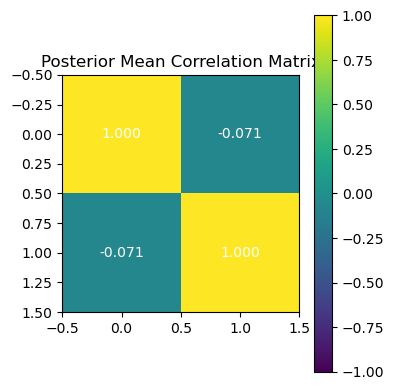

In [10]:
# Extract from your copula_trace
corr_samples = copula_trace.posterior['chol_cov_corr'].values  # shape: (chains, draws, 2, 2)
mean_corr = corr_samples.mean(axis=(0, 1))

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
cax = ax.imshow(mean_corr, vmin=-1, vmax=1, cmap='viridis')
plt.title("Posterior Mean Correlation Matrix")

for i in range(mean_corr.shape[0]):
    for j in range(mean_corr.shape[1]):
        ax.text(j, i, f"{mean_corr[i, j]:.3f}", va='center', ha='center', color='white')

fig.colorbar(cax, ax=ax)
plt.tight_layout()
plt.show()

#### 3. Describe what a copula is and how the two verions of code implement it 

A **copula** is a function that allows us to model the dependency structure between random variables separately from their individual (marginal) distributions. It works by transforming each variable into a uniform distribution using its cumulative distribution function (CDF), then modeling their joint behavior using a copula — such as the Gaussian copula, which applies a multivariate normal distribution to the transformed values. This approach is especially useful when the marginals are non-Gaussian but we still want to capture their joint dependencies.

In the one-pass method (your original PyMC code), both the marginals and their dependencies are modeled together in a single Bayesian framework. Each marginal distribution is specified inside PyMC, transformed into a latent normal space, and joined through a multivariate normal distribution with an LKJ prior on the correlation matrix. This allows full posterior inference but is computationally intensive. In contrast, the two-pass method (used in your PyMC copula model with `Age_Standardized` and `Purchase_Amount`) fits each marginal distribution separately, transforms the observed values externally to copula space, and then fits a multivariate normal copula model on those transformed values. While easier to implement and scale, it does not fully account for uncertainty from the marginal fits when estimating the dependency.

#### 4. Describe how to use this to create arbitrary multivariate GLM regressions

To create **arbitrary multivariate Generalized Linear Model (GLM) regressions** using copulas, the idea is to model each response variable using its own GLM appropriate to its data type (e.g., Poisson for counts, Gamma for positive skewed data), and model their joint dependence structure using a copula. This allows us to model heterogeneous outcomes (e.g., one binary, one continuous), while still accounting for their correlations.

The default workflow is to: (1) fit separate GLMs to each response variable with its own link and predictors, (2) transform the residuals or predicted values to uniform space through the CDF of the fitted marginal distribution, (3) map these to latent Gaussian variables through the inverse normal CDF (to copula space), and (4) fit a multivariate normal distribution over the transformed values, optionally using a Gaussian copula with an LKJ prior on the correlation matrix. This allows for rich joint modeling while preserving the interpretability and flexibility of GLMs.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.


In [16]:
file_path = "/home/jovyan/STA365/Ecommerce_Consumer_Behavior_Analysis_Data.csv"
df = pd.read_csv(file_path)

In [17]:
df.head()

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


In [18]:
# Re-import required packages after code reset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Select relevant columns for multivariate regression and variable selection, this step is just basically from common knowledge 
#and i've also removed variables such as location which are very hard to quantify.
columns_to_use = [
    "Age", 
    "Customer_Satisfaction", 
    "Return_Rate", 
    "Discount_Sensitivity", 
    "Engagement_with_Ads", 
    "Purchase_Amount"
]
df_model = df[columns_to_use].dropna()

# Clean 'Purchase_Amount'
df_model["Purchase_Amount"] = df_model["Purchase_Amount"].replace('[\$,]', '', regex=True).astype(float)

# Encode 'Engagement_with_Ads' and 'Discount_Sensitivity'
ads_encoder = OrdinalEncoder(categories=[["None", "Low", "Medium", "High"]])
sensitivity_encoder = OrdinalEncoder(categories=[["Not Sensitive", "Somewhat Sensitive", "Very Sensitive"]])

df_model["Engagement_with_Ads_Encoded"] = ads_encoder.fit_transform(df_model[["Engagement_with_Ads"]])
df_model["Discount_Sensitivity_Encoded"] = sensitivity_encoder.fit_transform(df_model[["Discount_Sensitivity"]])

# Build final feature matrix X and response y
X_raw = df_model[[
    "Age", 
    "Customer_Satisfaction", 
    "Return_Rate", 
    "Discount_Sensitivity_Encoded", 
    "Engagement_with_Ads_Encoded"
]]
y_raw = df_model["Purchase_Amount"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Downsample for performance
X = X_scaled[:500]
y = y_raw.values[:500]

X[:5], y[:5]


(array([[ 1.59602263, -0.13357237,  0.08574457, -1.22684883,  1.15674377],
        [-1.08685319,  0.56137759,  0.08574457, -1.22684883, -1.28819193],
        [-1.40879829,  1.25632754, -1.16511734, -0.00818991, -1.28819193],
        [-1.08685319, -1.17599731,  0.08574457,  1.210469  ,  1.15674377],
        [-0.97953816, -0.13357237,  0.08574457, -0.00818991, -0.06572408]]),
 array([222.22, 426.22, 486.4 , 201.96, 418.83]))

In [20]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Spike-and-slab model for variable selection
with pm.Model() as spike_slab_model:
    n_features = X.shape[1]

    # Spike-and-slab priors
    inclusion = pm.Bernoulli('inclusion', p=0.5, shape=n_features)
    slab = pm.Normal('slab', mu=0, sigma=10, shape=n_features)
    beta = pm.Deterministic('beta', inclusion * slab)

    sigma = pm.HalfNormal('sigma', sigma=10)
    mu = pm.math.dot(X, beta)

    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    spike_slab_trace = pm.sample(draws=500, tune=500, chains=2, cores=1, target_accept=0.9, return_inferencedata=True)


Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [inclusion]
>NUTS: [slab, sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


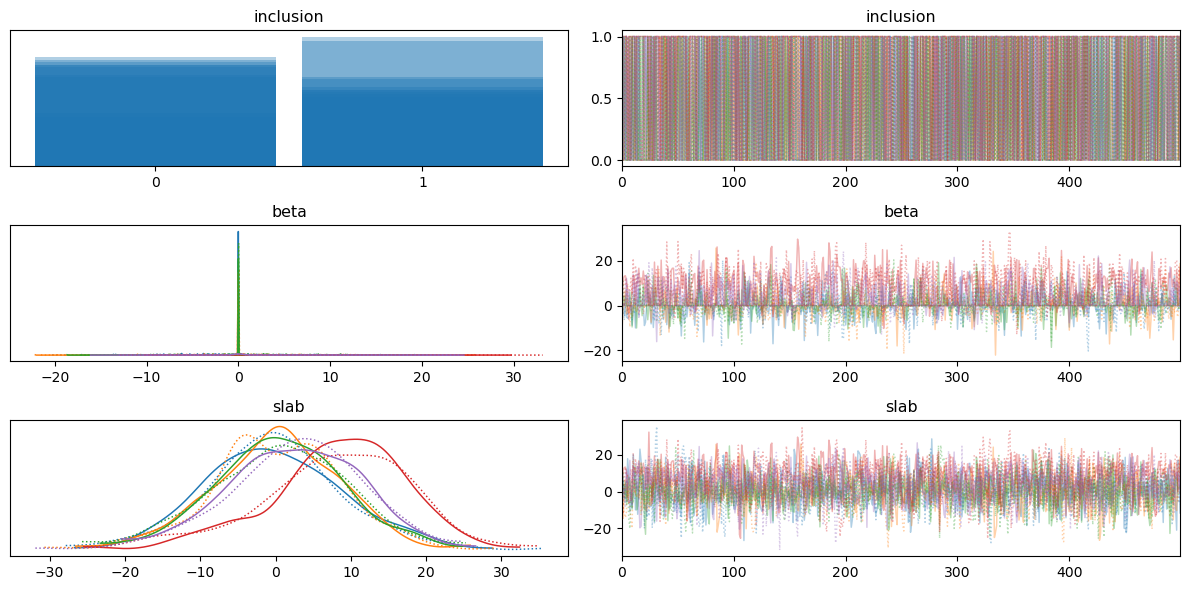

In [21]:
# Plot posterior of inclusion and beta for each variable
az.plot_trace(spike_slab_trace, var_names=["inclusion", "beta",'slab'])
plt.tight_layout()
plt.show()

In [24]:
with pm.Model() as diffuse_model:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1])  # diffuse prior
    sigma = pm.HalfNormal('sigma', sigma=10)
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    diffuse_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


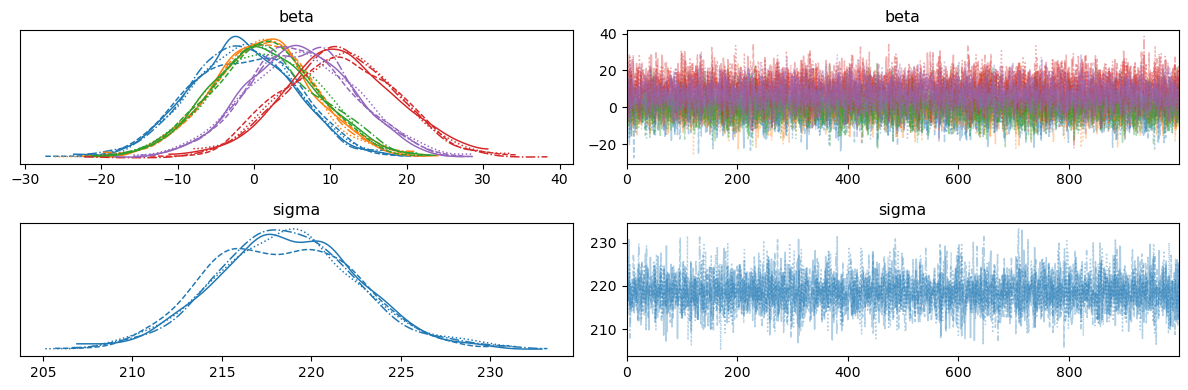

In [28]:
# Plot posterior of inclusion and beta for each variable
az.plot_trace(diffuse_trace, var_names=["beta",'sigma'])
plt.tight_layout()
plt.show()

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



In [29]:
with pm.Model() as horseshoe_model:
    n_features = X.shape[1]

    # Global shrinkage prior
    tau = pm.HalfCauchy("tau", beta=1)

    # Local shrinkage priors for each coefficient
    lambda_ = pm.HalfCauchy("lambda", beta=1, shape=n_features)

    # Coefficients with hierarchical variance
    beta = pm.Normal("beta", mu=0, sigma=tau * lambda_, shape=n_features)

    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = pm.math.dot(X, beta)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    horseshoe_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1017 divergences after tuning. Increase `target_accept` or reparameterize.


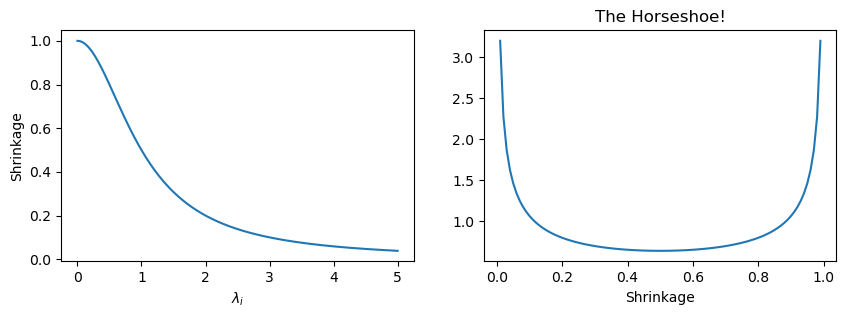

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$") 
# change of variables: 
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage, 
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

#### Comparison between horseshoe variable and spike/slab variable
The **horseshoe prior** and the **spike-and-slab prior** are both Bayesian approaches for variable selection in regression models, but they differ in how they encourage sparsity. The spike-and-slab prior explicitly models inclusion with a binary indicator for each coefficient, effectively performing hard selection—coefficients are either set to zero (excluded) or drawn from a wide "slab" distribution (included). In contrast, the horseshoe prior uses continuous, heavy-tailed shrinkage through a global-local hierarchy: each coefficient is scaled by both a global parameter (encouraging overall sparsity) and a local parameter (allowing large signals to escape shrinkage). This makes the horseshoe more computationally efficient and continuous in its selection behavior. Spike-and-slab is often more interpretable for strict inclusion/exclusion decisions, but the horseshoe offers smoother shrinkage and better scalability in high dimensions.